In [11]:
import numpy
import numpy as np
import src.models.model as NET_FCN  # The net Class
import torch
import torch.nn as nn
import torch.nn.functional as F
import src.models.loss_functions
import src.data.load_data as ReaderData
import src.data.make_dataset as MakeDataset

In [105]:
# TestFolder = r"data/interim/TranProteus8/Testing/LiquidContent" # input folder
TestFolder = r"data/interim/TranProteus/Testing/LiquidContent"  # input folder
# TestFolder = r"data/interim/LabPics Chemistry/Test" # input folder
# model_path =  r"models/40__29032023-0231.torch" # Trained model path
model_path = r"models/55__03042023-2211.torch"  # Trained model path

OutputStatisticsFile = "Statistics.txt"
MaxSize = 3000  # max image dimension
UseChamfer = False  # Evaluate chamfer distance (this takes lots of time)
# SetNormalizationUsing="ContentXYZ"
SetNormalizationUsing = (
    "VesselXYZ"  # Normalize prediction scale to GT scale by matching the vessel scale
)
UseGPU = True  # Use GPU for inference
batch_size = 1  # Batch size

In [217]:
# define masks and depth maps to predict
MaskClasses = {}
DepthList = ["EmptyVessel_Depth", "ContentDepth", "VesselOpening_Depth"]
MaskList = [
    "VesselMask",
    "ContentMaskClean",
    "VesselOpeningMask",
]  # List of segmentation Masks to predict
depth2Mask = {
    "EmptyVessel_Depth": "VesselMask",
    "ContentDepth": "ContentMaskClean",
    "VesselOpening_Depth": "VesselOpeningMask",
}  # Connect depth map to segmentation mask

In [218]:
model = NET_FCN.Net(MaskList=MaskList, DepthList=DepthList)
# Load model weights depending on GPU usage
if UseGPU == True:
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

Net(
  (Encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [219]:
# define masks and depth maps to predict
MaskClasses = {}
DepthList = ["EmptyVessel_Depth", "ContentDepth"]
MaskList = ["VesselMask", "ContentMaskClean"]  # List of segmentation Masks to predict
depth2Mask = {
    "EmptyVessel_Depth": "VesselMask",
    "ContentDepth": "ContentMaskClean",
}  # Connect depth map to segmentation mask

In [220]:
# load all folders in data/interim/initial

import os
import numpy as np
import cv2
import src.visualization.visualize as vis


def load_data(path):
    """
    Load all folders in path and return a list of numpy arrays
    """
    data = []
    for folder in os.listdir(path):
        print(folder)
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            # join filepath with /
            file_path = os.path.join(folder_path, file)
            file_path = folder_path + "/" + file

            print(file_path)
            # take RGB image
            if file_path.endswith("RGBImage.png"):
                # image = np.load(file_path)
                # Load image
                image = cv2.imread(file_path)
                print(image.shape)
                image = vis.ResizeToMaxSize(image, MaxSize)
                image = np.expand_dims(image, axis=0)
                print(image.shape)
                with torch.no_grad():
                    PrdDepth, PrdProb, PrdMask = model.forward(
                        Images=image, TrainMode=False, UseGPU=UseGPU
                    )
                """
                for nm in DepthList:
                    Pdepth = PrdDepth[nm]
                    Pdepth = Pdepth[0, 0, :, :].cpu().numpy()
                    np.save(file_path.replace('RGBImage.png', nm + '.npy'), Pdepth)
                for nm in MaskList:
                    Pmask = PrdMask[nm]
                    Pmask = Pmask[0, 0, :, :].cpu().numpy()
                    np.save(file_path.replace('RGBImage.png', nm + '.npy'), Pmask)
                """
                Prd = {}
                for nm in PrdDepth:
                    # convert to numpy and transpose to (H,W,C)
                    Prd[nm] = (
                        (PrdDepth[nm].transpose(1, 2).transpose(2, 3))
                        .data.cpu()
                        .numpy()
                    )
                    # print("Predicted Depth Map: ", Prd[nm].shape)
                for nm in PrdMask:
                    # convert to numpy
                    Prd[nm] = (PrdMask[nm]).data.cpu().numpy()

                # loop over all masks and depth maps
                for nm in Prd:
                    if nm in MaskList:
                        np.save(file_path.replace("RGBImage.png", nm + ".npy"), Prd[nm])
                        # copy mask for visualization
                        tmIm = Prd[nm][0].copy()
                        # normalize mask to values between 0-255
                        if (
                            Prd[nm][0].max() > 255
                            or Prd[nm][0].min() < 0
                            or np.ndim(Prd[nm][0]) == 2
                        ):
                            if tmIm.max() > tmIm.min():  #
                                tmIm[tmIm > 1000] = 0
                                tmIm = tmIm - tmIm.min()
                                tmIm = tmIm / tmIm.max() * 255
                            if np.ndim(tmIm) == 2:
                                tmIm = cv2.cvtColor(
                                    tmIm.astype(np.uint8), cv2.COLOR_GRAY2BGR
                                )

                        image = Prd[nm].squeeze()
                        print(image.shape)
                        image = image / image.max()
                        image = image * 255
                        image = image.astype(np.uint8)
                        cv2.imwrite(
                            file_path.replace("RGBImage.png", nm + ".png"), image
                        )

                    else:
                        # Prd[nm] = Prd[nm].squeeze()
                        # copy depth map for visualization
                        tmIm = Prd[nm].copy()
                        tmIm = tmIm.squeeze()
                        np.save(file_path.replace("RGBImage.png", nm + ".npy"), tmIm)

                        # squeeze depth map
                        # tmIm = tmIm.squeeze()
                        if nm in depth2Mask:
                            # Remove region out side of the object mask from the depth mask
                            tmIm[Prd[depth2Mask[nm]][0] == 0] = 0
                            np.save(
                                file_path.replace(
                                    "RGBImage.png", nm + "_segmented.npy"
                                ),
                                tmIm,
                            )

                            # normalize the rest of the depth map to values between 0-255
                            tmIm[Prd[depth2Mask[nm]][0] == 1] += 10
                            # if mask exists:
                            # if mask exists:
                            if tmIm[Prd[depth2Mask[nm]][0] == 1] != []:
                                min = tmIm[Prd[depth2Mask[nm]][0] == 1].min()
                                max = tmIm[Prd[depth2Mask[nm]][0] == 1].max()
                                tmIm[Prd[depth2Mask[nm]][0] == 1] = (
                                    tmIm[Prd[depth2Mask[nm]][0] == 1] - min
                                )
                                max = tmIm[Prd[depth2Mask[nm]][0] == 1].max()
                                tmIm[Prd[depth2Mask[nm]][0] == 1] = (
                                    tmIm[Prd[depth2Mask[nm]][0] == 1] / max * 255
                                )

                                image = tmIm.squeeze()
                                print(image.shape)
                                # image = image / image.max()
                                # image = image * 255
                                image = image.astype(np.uint8)
                                # save image
                                cv2.imwrite(
                                    file_path.replace(
                                        "RGBImage.png", nm + "_Segmented.png"
                                    ),
                                    image,
                                )

                """
                for nm in PrdMask:
                    # convert to numpy
                    Prd[nm] = (PrdMask[nm]).data.cpu().numpy()
                    print(nm, Prd[nm].shape)
                    # print size of mask
                    np.save(file_path.replace('RGBImage.png', nm + '.npy'), Prd[nm])
                    # also save the mask as png
                    image = Prd[nm].squeeze()
                    image[image == 1] = 255
                    print(image.shape)
                    cv2.imwrite(file_path.replace('RGBImage.png', nm + '.png'), image)

                for nm in PrdDepth:
                    print(nm)
                    # convert to numpy and transpose to (H,W,C)
                    Prd[nm] = (PrdDepth[nm].transpose(1, 2).transpose(2, 3)).data.cpu().numpy()
                    np.save(file_path.replace('RGBImage.png', nm + '.npy'), Prd[nm])
                    # also save the depth as png
                    image = Prd[nm].squeeze()
                    print(image.shape)
                    image = image / image.max()
                    image = image * 255
                    image = image.astype(np.uint8)

                    cv2.imwrite(file_path.replace('RGBImage.png', nm + '.png'), image)
                    
                    print("saved")
                    if nm in depth2Mask:

                        # copy depth map for visualization
                        tmIm = Prd[nm].copy()
                        # squeeze depth map
                        tmIm = tmIm.squeeze()
                        if nm in depth2Mask:
                            # Remove region out side of the object mask from the depth mask
                            tmIm[Prd[depth2Mask[nm]][0] == 0] = 0
                            # normalize the rest of the depth map to values between 0-255
                            tmIm[Prd[depth2Mask[nm]][0] == 1] += 10
                            # if mask exists:
                            min = tmIm[Prd[depth2Mask[nm]][0] == 1].min()
                            max = tmIm[Prd[depth2Mask[nm]][0] == 1].max()
                            tmIm[Prd[depth2Mask[nm]][0] == 1] = (
                                tmIm[Prd[depth2Mask[nm]][0] == 1] - min
                            )
                            max = tmIm[Prd[depth2Mask[nm]][0] == 1].max()
                            tmIm[Prd[depth2Mask[nm]][0] == 1] = (
                                tmIm[Prd[depth2Mask[nm]][0] == 1] / max * 255
                            )
                        
                        tmIm = Prd[nm].copy()
                        # squeeze depth map
                        tmIm = tmIm.squeeze()
                        # Remove region out side of the object mask from the depth mask
                        tmIm[Prd[depth2Mask[nm]][0] == 0] = 0
                        # Save depth map
                        np.save(file_path.replace('RGBImage.png', nm + '_Segmented.npy'), tmIm)

                        # normalize the rest of the depth map to values between 0-255
                        tmIm[Prd[depth2Mask[nm]][0] == 1] += 10
                        # if mask exists:
                        min = tmIm[Prd[depth2Mask[nm]][0] == 1].min()
                        max = tmIm[Prd[depth2Mask[nm]][0] == 1].max()
                        tmIm[Prd[depth2Mask[nm]][0] == 1] = (
                            tmIm[Prd[depth2Mask[nm]][0] == 1] - min
                        )
                        max = tmIm[Prd[depth2Mask[nm]][0] == 1].max()
                        tmIm[Prd[depth2Mask[nm]][0] == 1] = (
                            tmIm[Prd[depth2Mask[nm]][0] == 1] / max * 255
                            )
                        # also save the depth as png
                        image = tmIm.squeeze()
                        print(image.shape)
                        #image = image / image.max()
                        #image = image * 255
                        image = image.astype(np.uint8)
                        # save image
                        cv2.imwrite(file_path.replace('RGBImage.png', nm + '_Segmented.png'), image)
                        """

In [221]:
path = os.path.join("..", "data", "interim", "initial")

In [222]:
path = "data/interim/initial/"

In [223]:
load_data(path)

duran250_100ml_1104_0842
data/interim/initial/duran250_100ml_1104_0842/ColorImage.npy
data/interim/initial/duran250_100ml_1104_0842/DepthImage.npy
data/interim/initial/duran250_100ml_1104_0842/DepthMap.png
data/interim/initial/duran250_100ml_1104_0842/RGBImage.png
(480, 640, 3)
(1, 480, 640, 3)


C:\Users\apo_n\AppData\Local\Temp\ipykernel_13820\433417940.py:99: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if tmIm[Prd[depth2Mask[nm]][0] == 1] != []:
C:\Users\apo_n\AppData\Local\Temp\ipykernel_13820\433417940.py:99: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if tmIm[Prd[depth2Mask[nm]][0] == 1] != []:
C:\Users\apo_n\AppData\Local\Temp\ipykernel_13820\433417940.py:76: RuntimeWarning: invalid value encountered in divide
  image = image / image.max()


(480, 640)
(480, 640)
(480, 640)
(480, 640)
data/interim/initial/duran250_100ml_1104_0842/vessel.txt
data/interim/initial/duran250_100ml_1104_0842/vol_liquid.txt
data/interim/initial/duran250_100ml_1104_0842/vol_vessel.txt
duran250_100ml_1104_0950
data/interim/initial/duran250_100ml_1104_0950/ColorImage.npy
data/interim/initial/duran250_100ml_1104_0950/DepthImage.npy
data/interim/initial/duran250_100ml_1104_0950/DepthMap.png
data/interim/initial/duran250_100ml_1104_0950/RGBImage.png
(480, 640, 3)
(1, 480, 640, 3)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
data/interim/initial/duran250_100ml_1104_0950/vessel.txt
data/interim/initial/duran250_100ml_1104_0950/vol_liquid.txt
data/interim/initial/duran250_100ml_1104_0950/vol_vessel.txt
duran250_100ml_1104_1016
data/interim/initial/duran250_100ml_1104_1016/ColorImage.npy
data/interim/initial/duran250_100ml_1104_1016/DepthImage.npy
data/interim/initial/duran250_100ml_1104_1016/DepthMap.png
data/interim/initial/duran250_100ml_1104_1016/RGBIma

float32
(1, 120, 160, 1)
3.7104867 1.7612517
(array([1.7612517, 1.790636 , 1.7976626, ..., 3.6775064, 3.7038794,
       3.7104867], dtype=float32), array([1, 1, 1, ..., 1, 1, 1], dtype=int64))
(120, 160, 3)


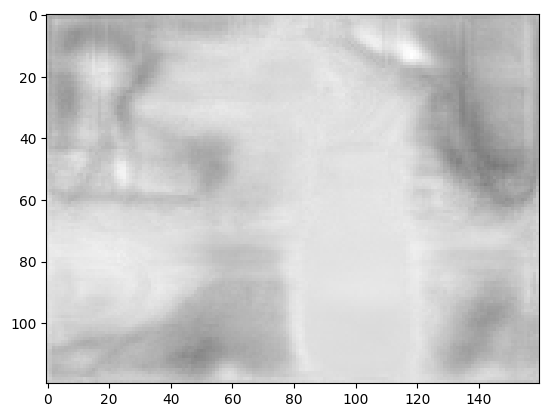

In [131]:
# read .npy file and show it as picture
import matplotlib.pyplot as plt
import numpy as np

# load the image
image = np.load("data/interim/initial/duran250_100ml_1104_0842/ContentDepth.npy")
# summarize shape of the pixel array
print(image.dtype)
print(image.shape)
# display the array of pixels as an image
image = image.squeeze()
file_path = "data/interim/initial/duran250_100ml_1104_0842/RGBImage.png"
print(image.max(), image.min())
# count values in image
print(np.unique(image, return_counts=True))
# normalize image
image = image / image.max()
image = image * 255
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image = image.astype(np.uint8)
cv2.imwrite(file_path.replace("RGBImage.png", "1" + ".png"), image)
print(image.shape)
plt.imshow(image)
plt.show()

In [87]:
print(image)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [148]:
image = np.load(
    "data/interim/initial/duran250_100ml_1104_0842/ContentDepth_Segmented.npy"
)
print(image)
# print amount of non zero values
print(np.count_nonzero(image))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
12164
